# Generate Synthetic data with non-linear, coupled, contemporaneous relationships

In [1]:
import sys
sys.path.append("../") # if running from this folder
from matplotlib import pyplot as plt
import torch
from src.data.causal_graph import SyntheticTCG, construct_temporaneous_data
from IPython.display import SVG
from lingam.utils import make_dot
from src.utils import get_model_device

C:\Users\mauri\anaconda3\envs\causal-discovery\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Settings

In [2]:
N = 8     # num nodes
E = 1     # num external nodes
K = 30    # max lags
T = 1000  # sequence length
milestones = [0, 400, 600]  # start with cm1, change to cm2 at t=400, change back to cm1 at t=600

file_name = f"synthetic_N-{N}_T-{T}_K-{K}"

Function for rendering the graph.

In [3]:
def render_graph(causal_graph, file_name):
    labels = [f"N{i}" for i in range(causal_graph.num_internal_nodes)] + [f"E{i}" for i in range(causal_graph.num_external_nodes)]
    dot_graph = make_dot(causal_graph.get_causal_matrix(), labels=labels)
    dot_graph.format = 'svg'
    dot_graph.render(file_name, cleanup=True)

## Generate the causal graph structure
Iterate on this cell until you find a graph that you like. 

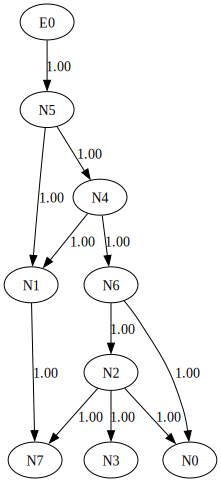

In [4]:
causal_graph_1 = SyntheticTCG(num_internal_nodes=N, max_lags=K, min_incoming_connections=1, num_external_nodes=E, num_ext_connections=1)
file_name_1 = f'{file_name}_1'
render_graph(causal_graph_1, file_name_1)
SVG(f'{file_name_1}.svg')

This function initializes the non-linear functions according to the graph by training them on random data points.

In [5]:
causal_graph_1.init_functional_relationships()

Training.. Loss=0.0346: 100%|██████████████████████████████████████████████████████| 2500/2500 [00:29<00:00, 84.79it/s]


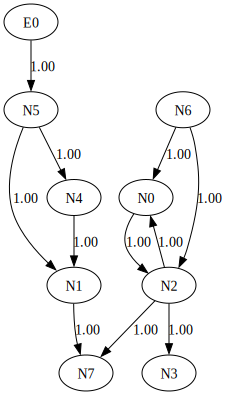

In [6]:
causal_graph_2 = causal_graph_1.permute_random_connection()
file_name_2 = f'{file_name}_2'
render_graph(causal_graph_2, file_name_2)
SVG(f'{file_name_2}.svg')

In [7]:
mile_stone_config = list(zip(milestones, [causal_graph_1, causal_graph_2, causal_graph_1]))
data, data_mean, gt = construct_temporaneous_data(mile_stone_config, sequence_length=T, warmup=500)

Generating temporal data..: 100%|████████████████████████████████████████████████| 1501/1501 [00:01<00:00, 1351.15it/s]


In [8]:
print("data     :", data.size())
print("data_mean:", data_mean.size())
print("gt       :", gt.size())

data     : torch.Size([1, 8, 1000])
data_mean: torch.Size([1, 8, 1000])
gt       : torch.Size([1, 8, 9, 1000])


In [10]:
path = f"{file_name}.pt"
torch.save({'data': data, 'data_mean': data_mean, 'gt': gt}, path)
print(f"Written to '{path}'!")

Written to 'synthetic_N-8_T-1000_K-30.pt'!


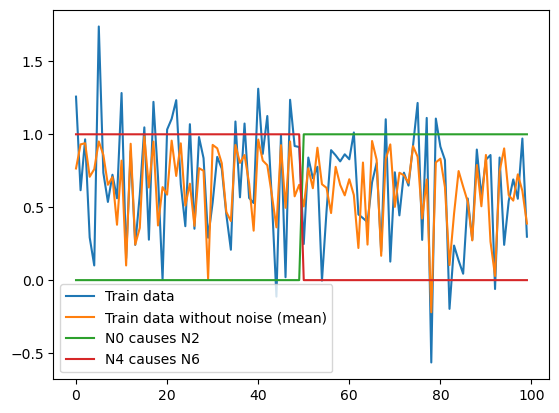

In [23]:
node_from, node_to = 0, 2

plt.plot(data[0, node_from, 350:450], label=f"Train data")
plt.plot(data_mean[0, node_from, 350:450], label=f"Train data without noise (mean)")
plt.plot(gt[0, 2, 0, 350:450], label=f"N0 causes N2")
plt.plot(gt[0, 6, 4, 350:450], label=f"N4 causes N6")

plt.legend()